In [28]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.plotting import *
from src.generate_data import *
from src.real_data import *
from src.enhancer import *

import sklearn
import pandas as pd

from scipy.stats import bernoulli

from operator import xor

import os


In [29]:
dataset = "enhancer_imbalanced"
noise_type = "group"

batch_size = 512


In [30]:
dataset = "enhancer"

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_dir, "data", dataset, dataset+"_data.csv")

df = pd.read_csv(data_path)

# mask = df["pValueAdjusted"] > 0.5

# #Flip the noisy labels (True ↔ False) only for those rows
# df.loc[mask, 'Significant'] = ~df.loc[mask, 'Significant']

# print(len(df))

In [31]:
df = df[df["pValueAdjusted"]<0.5]

In [32]:
df["Regulated"].value_counts()

Regulated
False    574
True     418
Name: count, dtype: int64

In [33]:
df["Significant"].value_counts()

Significant
False    512
True     480
Name: count, dtype: int64

In [34]:
df_regulated = df["Regulated"].values
df_significant = df["Significant"].values

agreements = np.sum(df_regulated == df_significant)

# Compute disagreements
only_regulated = np.sum((df_regulated == 1) & (df_significant == 0))  # (1, 0) case
only_significant = np.sum((df_regulated == 0) & (df_significant == 1))  # (0, 1) case

# Output results
print("Total agreements:", agreements)
print("Disagreements where Regulated=1 and Significant=0:", only_regulated)
print("Disagreements where Regulated=0 and Significant=1:", only_significant)

Total agreements: 930
Disagreements where Regulated=1 and Significant=0: 0
Disagreements where Regulated=0 and Significant=1: 62


In [35]:
features, labels, noisy_labels, power, p_value, effect, groups = load_enhancer()

In [36]:
# Get unique values and their counts
unique_values, counts = np.unique(labels, return_counts=True)

# Display result
print("Unique values:", unique_values)
print("Counts:", counts)

Unique values: [0 1]
Counts: [574 418]


In [37]:
X_train, X_test, y_train, y_test, yn_train, yn_test, effect_train, effect_test, group_train, group_test = enhancer_train_test_split(features, labels, noisy_labels, effect, test_size=0.2, random_state=2028)
# Get unique values and their counts
unique_values, counts = np.unique(y_test, return_counts=True)

# Display result
print("Unique values:", unique_values)
print("Counts:", counts)

Unique values: [0 1]
Counts: [116  91]


In [38]:
n_models = 1000
max_iter = 10000
model_type = "LR"
epsilon = 0.1
noise_level = 0.05 #T1 Error

In [39]:
def generate_abstain_data_enhancer(n_models, max_iter, model_type = "LR", epsilon = 0.1):
    
    losses, draw_ids =  [], []
    
    plausible_labels_train_all, plausible_labels_test_all  = [], []
    
    preds_train_all, preds_test_all = [], []
    
    probs_train_all, probs_test_all = [], []

    final_model_probs_train_all, final_model_probs_test_all = [], []
    
    features, labels, noisy_labels, power, p_value, effect, groups = load_enhancer()
    
    for draw_id in [2025, 2026, 2027, 2028, 2029]:
        X_train, X_test, y_train, y_test, yn_train, yn_test, effect_train, effect_test, group_train, group_test = enhancer_train_test_split(features, labels, noisy_labels, effect, test_size=0.2, random_state=draw_id)


        yn_train = yn_train.astype(int)
        yn_test = yn_test.astype(int)

        y_train = y_train.astype(int)
        y_test = y_test.astype(int)

        p_y_x_dict =  calculate_prior(y_train, group=group_train) #Clean prior

        T_dict = generate_T_dict(power, p_value, groups)
        
    
        plausible_labels_train, plausible_labels_test, preds_train, preds_test, probs_train, probs_test = run_procedure_abstain(
                            n_models, max_iter, X_train, yn_train, X_test, yn_test, y_test, p_y_x_dict, 
                            group_train=group_train, group_test=group_test, noise_type="group", 
                            model_type=model_type, T=T_dict, epsilon=epsilon, misspecify=True)
        
        
         # Train final model on noisy labels
        model, (train_acc, test_acc, train_probs, test_probs, 
                train_loss, test_loss, train_preds, test_preds) = train_model_ours_regret(
            X_train, yn_train, X_test, y_test, seed=2029, model_type=model_type)
        
        # Store results

        losses.append("BCE")
        draw_ids.append(draw_id)

        plausible_labels_train_all.append(plausible_labels_train)
        plausible_labels_test_all.append(plausible_labels_test)
        
        preds_train_all.append(preds_train)
        preds_test_all.append(preds_test)
        
        probs_train_all.append(probs_train)
        probs_test_all.append(probs_test)

        final_model_probs_train_all.append(train_probs)
        final_model_probs_test_all.append(test_probs)

    # Convert results into a structured dictionary
    data = {

        "loss": losses,
        "plausible_labels_train": plausible_labels_train_all,
        "plausible_labels_test": plausible_labels_test_all,
        "probs_train": probs_train_all,
        "probs_test": probs_test_all,
        "preds_train": preds_train_all,
        "preds_test": preds_test_all,
        "final_model_probs_train": final_model_probs_train_all,
        "final_model_probs_test": final_model_probs_test_all,

        "draw_id": draw_ids
    }
    return data


def compute_abstain_metrics_enhancer(preds, criteria, y_vec, yn_vec, abstain_percentage):
    """
    Compute abstention-aware classification metrics for enhancer discovery.

    Args:
        preds (np.ndarray): Predicted labels (binary: 0 or 1).
        y_vec (np.ndarray): True labels (binary: 0 or 1).
        y_vec (np.ndarray): Noisy labels (binary: 0 or 1).
        criteria (np.ndarray): Abstention criteria scores for each instance.
        abstain_percentage (float): Percentage of instances to abstain.
        cost_per_experiment (float): Cost per experiment (default = 1.0).

    Returns:
        dict: Dictionary of computed metrics including PPV, Recall, Specificity, FDR, Abstention Rate, etc.
    """
    n = len(preds)
    
    # Determine abstained instances
    abstain_count = int(abstain_percentage * n)
    abstain = abstain_order(criteria, abstain_count)
    non_abstain = (1 - abstain).astype(bool)  # Mask of non-abstained instances

    coverage = np.sum(non_abstain) / n  # Fraction of retained instances
    abstention_rate = 1 - coverage  # Proportion of abstained cases

    # Subset data for evaluation
    preds_subset = preds[non_abstain]
    y_subset = y_vec[non_abstain]

    err_true = abs(preds - y_vec)  # Full error vector
    subset_err_true = err_true[non_abstain]
    
    err_anticipated = abs(preds - yn_vec)  # full err_anticipated
    subset_err_anticipated = err_anticipated[non_abstain]
    
    regret = (1/n)*np.sum(abs(subset_err_anticipated - subset_err_true))/ coverage if coverage > 0 else 0.0
    
    # Clean risk (Test Error)
    risk = np.sum(subset_err_true) / (n * coverage) if coverage > 0 else 0.0

    # Compute Confusion Matrix Components
    tp = np.sum((preds_subset == 1) & (y_subset == 1))  # True Positives
    fp = np.sum((preds_subset == 1) & (y_subset == 0))  # False Positives
    tn = np.sum((preds_subset == 0) & (y_subset == 0))  # True Negatives
    fn = np.sum((preds_subset == 0) & (y_subset == 1))  # False Negatives
    
    # PPV (Precision)
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0

    # Sensitivity / Recall (TPR)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    # Specificity (TNR)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # False Discovery Rate (FDR)
    fdr = fp / (tp + fp) if (tp + fp) > 0 else 0.0

    # Discovery Rate (Proportion of experiments still performed)
    discovery_rate = (tp + fp) / np.sum(non_abstain) if np.sum(non_abstain) > 0 else 0.0

   
    return {
        'coverage': 100 * coverage,
        'abstention_rate': 100 * abstention_rate,
        'regret': 100 * regret,
        'risk': 100 * risk,
        'ppv': 100 * ppv,
        'recall': 100 * recall,
        'specificity': 100 * specificity,
        'fdr': 100 * fdr,
        'discovery_rate': 100 * discovery_rate
    }
    

def metrics_active_learning_enhancer(noise_type, model_type, data, fixed_class=0, fixed_noise=0.0, experiment_type = "abstain"):
    """
    Runs an experiment with two abstention handling strategies: "drop" and "relabel".
    
    Args:
        dataset (str): Name of the dataset.
        noise_type (str): Type of noise ("class_independent" or "class_conditional").
        model_type (str): Type of model to train.
        data (pd.DataFrame): Dataframe containing abstain-related results.
        fixed_class (int): Fixed class for noise generation.
        fixed_noise (float): Fixed noise level.

    Returns:
        pd.DataFrame: Results containing abstention metrics and retrained model performance.
    """
    results = []

    
    # Convert dataframe for faster processing
    df = pd.DataFrame(data)

    # Precompute unique values to avoid repeated calls
    unique_losses = df["loss"].unique()
    unique_draw_ids = df["draw_id"].unique()

    metric_lis = ["risk", "regret", "discovery_rate", "ppv", "fdr", "specificity", "recall"]
    abstain_percentages = np.linspace(0, 0.99, 200)

    for loss in unique_losses:
        for draw_id in  tqdm(unique_draw_ids, desc="Processing Draws"):

            # Load dataset splits
            X_train, X_test, y_train, y_test, yn_train, yn_test, effect_train, effect_test, group_train, group_test = enhancer_train_test_split(features, labels, noisy_labels, effect, test_size=0.2, random_state=draw_id)


            yn_train = yn_train.astype(int)
            yn_test = yn_test.astype(int)

            y_train = y_train.astype(int)
            y_test = y_test.astype(int)

            p_y_x_dict =  calculate_prior(y_train, group=group_train) #Clean prior

            T_dict = generate_T_dict(power, p_value, groups)


            # Compute noisy labels
#             u_vec = get_u(y_train, T=T_dict, seed=draw_id, noise_type=noise_type, group = group_train)
#             yn_train = flip_labels(y_train, u_vec) 

            # Filter once and reuse
            sub_df = df[(df["loss"] == loss) & (df["draw_id"] == draw_id)].iloc[0]

            plausible_labels_train = sub_df.plausible_labels_train
            plausible_labels_test = sub_df.plausible_labels_test
            probs_train, probs_test = sub_df.probs_train, sub_df.probs_test
            preds_train, preds_test = sub_df.preds_train, sub_df.preds_test
            model_probs_train, model_probs_test = sub_df.final_model_probs_train, sub_df.final_model_probs_test
            
            #model_preds_train = np.argmax(model_probs_train, axis=1)
            #model_preds_test = np.argmax(model_probs_test, axis=1)
            
            # Define a probability threshold for classifying as positive
            threshold = 0.5  # Adjust this value if needed
            
            # Apply thresholding across all models (each value represents P(y=1 | x))
#             preds_train = (probs_train >= threshold).astype(int)  # Shape: (m, k)
#             preds_test = (probs_test >= threshold).astype(int)  # Shape: (m, k)

            # Apply threshold-based classification
            model_preds_train = (model_probs_train[:, 1] >= threshold).astype(int)
            model_preds_test = (model_probs_test[:, 1] >= threshold).astype(int)


            # Compute various abstention criteria
            ambiguity_train = calculate_ambiguity(preds_train, plausible_labels_train)
            ambiguity_test = calculate_ambiguity(model_preds_test, preds_test)

            confidence_train = np.max(model_probs_train, axis=1)
            uncertainty_train = 1 - confidence_train

            confidence_test = np.max(model_probs_test, axis=1)
            uncertainty_test = 1 - confidence_test

            #mean_probs_plausible = np.mean(probs_test, axis=0)
            #confidence_plausible = np.abs(mean_probs_plausible - 0.5) * 2  # Scale to [0,1]
            #uncertainty_plausible = 1 - confidence_plausible

            #majority = compute_majority_vote(preds_test)
            #LOO = compute_loo(probs_test)

#             confidence_scores, prediction_sets, ambiguity_scores = conformal_prediction_plausible(
#                 probs_test, probs_train, plausible_labels, alpha=0.01
#             )

#             entropy = compute_entropy_score(probs_test)
#             disagreement_test = estimate_disagreement(probs_test)

            for abstain_pct in tqdm(abstain_percentages, desc="Processing Abstain Levels"):


                # Loop over test criteria methods
                for method_name, crit in [("confidence", uncertainty_test),
                                            ("ambiguity", ambiguity_test)]:

                    # Compute abstain metrics on TEST set
                    abstain_metrics = compute_abstain_metrics_enhancer(preds = model_preds_test,
                                                                       criteria = crit,
                                                                       abstain_percentage = abstain_pct, 
                                                                       y_vec=y_test, 
                                                                       yn_vec=yn_test)
                    for metric in metric_lis:
                        results.append({
                            "metric": metric,
                            "value": abstain_metrics[metric],
                            "coverage": abstain_metrics["coverage"],
                            "threshold": abstain_pct,
                            "loss": loss,
                            "draw_id": draw_id,
                            "method": method_name,
                            "experiment_type": "abstain"
                        })
                # Loop over training criteria methods
                for method_name, crit in [("confidence", uncertainty_train),
                                            ("ambiguity", ambiguity_train)]:
                    for exp_type in ["relabel", "drop"]:

                        abstain_count = int(abstain_pct * len(X_train))
                        abstain = abstain_order(crit, abstain_count)
                        non_abstain = (1 - abstain).astype(bool)
                        coverage = np.mean(non_abstain) * 100

                        if exp_type == "drop":
                            X_train_subset = X_train[non_abstain]
                            yn_train_subset = yn_train[non_abstain]
                        elif exp_type == "relabel":
                            yn_train_relabel = yn_train.copy()
                            yn_train_relabel[abstain.astype(bool)] = y_train[abstain.astype(bool)]
                            X_train_subset = X_train
                            yn_train_subset = yn_train_relabel

                        try:
                            # Retrain model using the selected strategy
                            model, (train_acc, test_acc, _, _, train_loss, test_loss, _, _) = train_model_ours_regret(
                                X_train_subset, yn_train_subset, X_test, y_test, 2024, model_type=model_type
                            )

                            # Compute abstain metrics on TEST set
                            abstain_metrics = compute_abstain_metrics_enhancer(reds = model_preds_test,
                                                                       criteria = crit,
                                                                       abstain_percentage = 0, 
                                                                       y_vec=y_test, 
                                                                       yn_vec=yn_test)

                            for metric in metric_lis:
                                results.append({
                                    "metric": metric,
                                    "value": abstain_metrics[metric],
                                    "coverage": coverage,
                                    "threshold": 0,
                                    "loss": loss,
                                    "draw_id": draw_id,
                                    "method": method_name,
                                    "experiment_type": "abstain"
                                })
                        except:
                            pass
                        


    return pd.DataFrame(results)



In [40]:
data = generate_abstain_data_enhancer(n_models, max_iter, epsilon = epsilon)



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [41]:
data

{'loss': ['BCE', 'BCE', 'BCE', 'BCE', 'BCE'],
 'plausible_labels_train': [array([[0, 0, 1, ..., 1, 0, 1],
         [0, 0, 1, ..., 1, 0, 1],
         [0, 0, 1, ..., 0, 0, 1],
         ...,
         [0, 0, 1, ..., 0, 0, 1],
         [0, 0, 1, ..., 1, 0, 0],
         [0, 0, 0, ..., 1, 0, 1]]),
  array([[0, 1, 1, ..., 0, 0, 0],
         [0, 1, 1, ..., 0, 1, 0],
         [0, 1, 1, ..., 0, 1, 0],
         ...,
         [0, 1, 1, ..., 0, 1, 0],
         [0, 1, 1, ..., 0, 1, 0],
         [0, 1, 0, ..., 0, 1, 0]]),
  array([[1, 0, 1, ..., 1, 0, 1],
         [1, 0, 1, ..., 1, 0, 1],
         [1, 0, 1, ..., 0, 0, 1],
         ...,
         [0, 0, 1, ..., 0, 0, 1],
         [1, 0, 1, ..., 1, 0, 0],
         [1, 0, 0, ..., 1, 0, 1]]),
  array([[0, 1, 1, ..., 1, 0, 0],
         [0, 1, 1, ..., 1, 0, 0],
         [0, 1, 1, ..., 0, 0, 0],
         ...,
         [0, 1, 1, ..., 0, 0, 0],
         [0, 1, 1, ..., 1, 0, 0],
         [0, 1, 0, ..., 1, 0, 0]]),
  array([[1, 0, 0, ..., 0, 0, 0],
         [1, 0

In [42]:
with open("enhancer.pkl", 'wb') as file:
            # Use pickle to write the dictionary to the file
    pkl.dump(data, file)

 

In [43]:
   
# with open("enhancer.pkl", 'rb') as file:
#             # Use pickle to write the dictionary to the file
#     data = pkl.load(file)
    
# pd.DataFrame(data)

In [44]:
all_metrics = metrics_active_learning_enhancer(noise_type, model_type, data, experiment_type = "abstain")

Processing Draws:   0%|          | 0/5 [00:00<?, ?it/s]

Processing Abstain Levels:   0%|          | 0/200 [00:00<?, ?it/s]

Processing Abstain Levels:   0%|          | 0/200 [00:00<?, ?it/s]

Processing Abstain Levels:   0%|          | 0/200 [00:00<?, ?it/s]

Processing Abstain Levels:   0%|          | 0/200 [00:00<?, ?it/s]

Processing Abstain Levels:   0%|          | 0/200 [00:00<?, ?it/s]

In [45]:
all_metrics

,metric,value,coverage,threshold,loss,draw_id,method,experiment_type
0,risk,19.806763,100.000000,0.00,BCE,2025,confidence,abstain
1,regret,7.246377,100.000000,0.00,BCE,2025,confidence,abstain
2,discovery_rate,48.309179,100.000000,0.00,BCE,2025,confidence,abstain
3,ppv,70.000000,100.000000,0.00,BCE,2025,confidence,abstain
4,fdr,30.000000,100.000000,0.00,BCE,2025,confidence,abstain
...,...,...,...,...,...,...,...,...
13995,discovery_rate,0.000000,1.449275,0.99,BCE,2029,ambiguity,abstain
13996,ppv,0.000000,1.449275,0.99,BCE,2029,ambiguity,abstain
13997,fdr,0.000000,1.449275,0.99,BCE,2029,ambiguity,abstain
13998,specificity,100.000000,1.449275,0.99,BCE,2029,ambiguity,abstain


In [46]:
import matplotlib.ticker as mtick


def plot_enhancer_metrics(data, loss_type="BCE", group=False):
    # Calculate the delta risk and delta auprc for abstention rate = 0
    data["abstention"] = 100-data["coverage"]
    data['method'] = data['method'].str.capitalize()
    
    data = data[data["coverage"]>0]
    data = data[data["method"]!= "Disagreement"]
    
    #data = data[data["draw_id"]==2028]
    # Define your custom color palette for each method
    
    methods_include = [""]
       
    method_colors = {
        "Ambiguity": "#8896FB",  # Purple
        "Majority":  "#800080",  # Red
        "Loo":  "#00FF00",
        "Mean_plausible":  "#228B22",
        "Conformal": "#93C572",
        "Confidence": "#ce3d26",
        "Entropy": "#2478d8",
        "Disagreement": "#1b334f"
        
    }
    
    # Define your custom color palette for each loss type
    loss_colors = {
        "BCE": "#8896FB",
        "forward": "#fc8803",
        "backward": "#4ed476"
    }
    
    # Set the font style to sans-serif
    plt.rcParams["font.family"] = "sans-serif"
    
    # Focus only on metrics where abstention rate is 0
    metrics = ["risk",
               "regret",
               "discovery_rate", 
               "ppv", 
               "fdr",
                "recall",
               "specificity"]
    
    # Create box plots for each metric at abstention rate = 0
    fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    
        # Calculate baseline values where threshold = 0 for each split, method, and metric
    baseline_data = data[data["abstention"] == 0].set_index(["draw_id", "metric", "method"])
    

    # Create a new DataFrame to store the deltas
    delta_data = []
    
    # Loop through each row where threshold is not 0
    for index, row in data[data["coverage"] != 0].iterrows():
        #baseline_value = baseline_data.loc[(row["draw_id"], row["metric"],  row["method"]), "value"]
        baseline_value = 0
        delta_value = row["value"] - baseline_value  # Calculate the delta
        delta_row = row.copy()
        delta_row["delta"] = delta_value  # Add the delta value to the new row
        delta_data.append(delta_row)

    # Convert the delta_data back into a DataFrame
    delta_data_df = pd.DataFrame(delta_data)

    y_labels = {"risk": "ΔTest Error", 
                "discovery_rate": "Discovery Rate", 
                "fdr": "False Discovery Rate",
                "specificity": "Specificity",
                "recall": "ΔHit Rate",
                "ppv": "PPV", 
                "num_pos": 
                "Positive Abstentions", 
                "regret":"Regret"}
    #y_labels = {"noisy_risk_subset": "Test Error %", "noisy_auprc_subset": "AUPRC %", "noisy_ppv_subset": "PPV %", "num_pos_subset": "Positive Predictions", "regret_subset":"Regret"}
    
    for metric, ax in zip(metrics, axes):
        method_data = delta_data_df[delta_data_df["metric"] == metric]
#         if metric == "noisy_risk":
#             method_data["delta"]= (method_data["delta"]*-1)
        

        sns.lineplot(data=method_data, x="abstention", y="delta", hue = "method", ax=ax, palette=method_colors)
        ax.legend().remove()  
        ax.set_xlabel("Abstention Rate", fontsize=14)
        ax.set_ylabel(y_labels[metric], fontsize=14)  # Use Δ symbol for delta
        #ax.set_title(f"{metric.replace('delta_', 'Δ ')}", fontsize=16)
        ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals = 0))
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals = 0))
        
        ax.yaxis.get_major_locator().set_params(integer=True)
    # Add a shared legend at the bottom, as close as possible without extra white space
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), fontsize=15, title_fontsize=16, ncol=3)
    
    plt.tight_layout()
    #plt.savefig('/h/snagaraj/noise_multiplicity/figures/enhancer.pdf', dpi=300, bbox_inches='tight')

   
    plt.show()




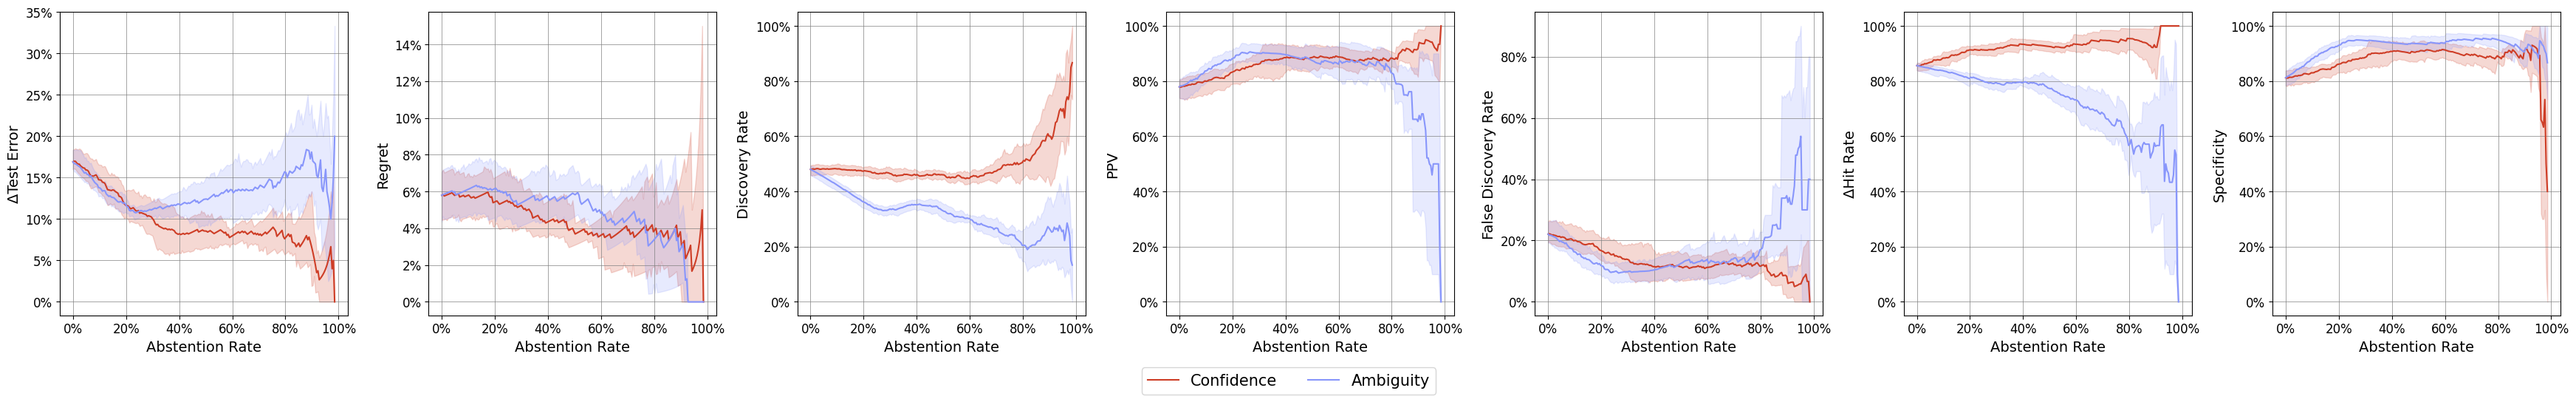

In [47]:
plot_enhancer_metrics(all_metrics, loss_type="BCE",  group = False)